# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [2]:
!pip -q install ./python

ERROR: Could not find a version that satisfies the requirement torch==0.4.0 (from unityagents)
ERROR: No matching distribution found for torch==0.4.0


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [6]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="./Banana_Windows_x86_64\Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [7]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
brain

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [9]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [10]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque
from collections import namedtuple
import numpy as np

class QNetwork(nn.Module):
    
    def __init__(self,state_size,action_size,seed,fc1_units=64,fc2_units=64):
        super(QNetwork,self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size,fc1_units)
        self.fc2 = nn.Linear(fc1_units,fc2_units)
        self.fc3 = nn.Linear(fc2_units,action_size)
        
    def forward(self,state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
        

In [2]:
q = QNetwork(4,3,10)
u = q.forward(torch.from_numpy(np.array([[1,2,3,4],[5,6,7,8]],dtype='float32')))
print(u)
print(u.detach().max(1))
print(u.detach().max(1)[0])
print(u.detach().max(1)[0].unsqueeze(0))
print(u.detach().max(1)[0].unsqueeze(1))

print('-------------')
v = q.forward(torch.from_numpy(np.array([[1,2,3,4],[5,6,7,8]],dtype='float32')))
print(v)
print(v.gather(1,torch.tensor([[0,0,0],[1,1,1]])))
print(v.gather(1,torch.tensor([[0],[1]])))

tensor([[0.3832, 0.5955, 0.8233],
        [0.9287, 1.2914, 1.8397]], grad_fn=<AddmmBackward>)
torch.return_types.max(
values=tensor([0.8233, 1.8397]),
indices=tensor([2, 2]))
tensor([0.8233, 1.8397])
tensor([[0.8233, 1.8397]])
tensor([[0.8233],
        [1.8397]])
-------------
tensor([[0.3832, 0.5955, 0.8233],
        [0.9287, 1.2914, 1.8397]], grad_fn=<AddmmBackward>)
tensor([[0.3832, 0.3832, 0.3832],
        [1.2914, 1.2914, 1.2914]], grad_fn=<GatherBackward>)
tensor([[0.3832],
        [1.2914]], grad_fn=<GatherBackward>)


In [3]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 5e-4
UPDATE_EVERY = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
class ReplayBuffer:
    
    def __init__(self,action_size,buffer_size,batch_size,seed):
        self.action_size = action_size
        self.memory = deque(maxlen = buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience",field_names=["state","action","reward","next_state","done"])
        self.seed = random.seed(seed)
        
    def add(self,state,action,reward,next_state,done):
        e = self.experience(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([1 if e.done else 0 for e in experiences if e is not None])).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        return len(self.memory)

In [5]:
class Agent():
    
    def __init__(self,state_size,action_size,seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        self.qnetwork_local = QNetwork(state_size,action_size,seed).to(device)
        self.qnetwork_target = QNetwork(state_size,action_size,seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=LR)
        
        self.memory = ReplayBuffer(action_size,BUFFER_SIZE,BATCH_SIZE,seed)
        self.t_step = 0
        
    def step(self,state,action,reward,next_state,done):
        self.memory.add(state,action,reward,next_state,done)
        
        #learn after UPDATE_EVERY time
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        self.t_step == 0
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences,GAMMA)
                
    def learn(self,experiences,gamma):
        states,actions,rewards,next_states,dones = experiences
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1,actions)
        
        loss = F.mse_loss(Q_expected,Q_targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.qnetwork_local,self.qnetwork_target,TAU)
        
    def soft_update(self,local_model,target_model,tau):
        
        for target_param,local_param in zip(target_model.parameters(),local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)
            
    def act(self,state,eps=0.):
        #epsilon greedy policy
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        

In [9]:
PATH = "./"
max_score = np.NINF
def dqn(env,agent,brain_name,n_episodes=2000,max_t=1000,eps_start=1.0,eps_end=0.01,eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps=eps_start
    for i_episode in range(1,n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state,eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state,action,reward,next_state,done)
            score += reward
            state = next_state
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end,eps*eps_decay)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode,np.mean(scores_window)),end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode,np.mean(scores_window)))
    return scores
        

In [10]:
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [11]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


In [12]:
import matplotlib.pyplot as plt
agent = Agent(state_size,action_size,seed=0)
scores = dqn(env,agent,brain_name)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 0.92
Episode 200	Average Score: 4.42
Episode 300	Average Score: 7.47
Episode 400	Average Score: 9.54
Episode 500	Average Score: 10.93
Episode 600	Average Score: 12.72
Episode 700	Average Score: 13.56
Episode 800	Average Score: 12.69
Episode 900	Average Score: 13.83
Episode 1000	Average Score: 14.36
Episode 1100	Average Score: 15.68
Episode 1200	Average Score: 14.31
Episode 1300	Average Score: 13.95
Episode 1400	Average Score: 15.03
Episode 1500	Average Score: 15.63
Episode 1600	Average Score: 15.50
Episode 1700	Average Score: 14.71
Episode 1800	Average Score: 14.41
Episode 1900	Average Score: 13.60
Episode 2000	Average Score: 14.14


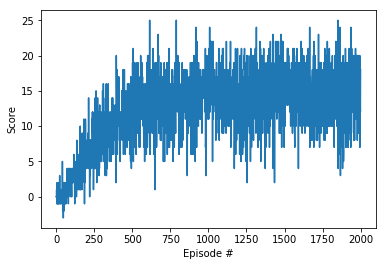

In [13]:
plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [14]:
torch.save(agent.qnetwork_local.state_dict(),'modelloss14.pth')

In [18]:
trained_model = QNetwork(state_size, action_size,0).to(device)
trained_model.load_state_dict(torch.load('modelloss14.pth'))
trained_model.eval()
agent1 = Agent(state_size, action_size,0)
agent1.qnetwork_local = trained_model

In [19]:
env.close()

In [ ]:
!tar chvfz nanotebook.tar.gz *

In [6]:
#Testing
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="./Banana_Windows_x86_64\Banana_Windows_x86_64/Banana.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


In [7]:
test_agent = Agent(state_size,action_size,seed=0)
trained_model = QNetwork(state_size, action_size,0).to(device)
trained_model.load_state_dict(torch.load('./modelloss14.pth'))
trained_model.eval()
test_agent.qnetwork_local = trained_model
test_agent.qnetwork_local = test_agent.qnetwork_local.to(device)

In [8]:
for _ in range(5):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = torch.argmax(test_agent.qnetwork_local.forward(torch.from_numpy(np.array(state,dtype='float32')).to(device))) # select an action
        env_info = env.step(action.item())[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break

    print("Score: {}".format(score))

env.close()

Score: 16.0
Score: 17.0
Score: 15.0
Score: 12.0
Score: 17.0


In [ ]:
env.close()

In [ ]:


# env_info = env.reset(train_mode=True)[brain_name] # reset the environment
# state = env_info.vector_observations[0]            # get the current state
# score = 0                                          # initialize the score
# agent = Agent(state_size,action_size,seed=0)
# while True:
#     action = np.random.randint(action_size)        # select an action
#     env_info = env.step(action)[brain_name]        # send the action to the environment
#     next_state = env_info.vector_observations[0]   # get the next state
#     reward = env_info.rewards[0]                   # get the reward
#     done = env_info.local_done[0]                  # see if episode has finished
#     score += reward                                # update the score
#     state = next_state                             # roll over the state to next time step
#     if done:                                       # exit loop if episode finished
#         break
    
# print("Score: {}".format(score))
# env.close()